In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import re

The European Cup 2020 is planned to start on the 11th June 2021. The team selection of the managers will be announced close to this date. Therefore, we need to find secondary sources that predict the players that will be selected to play for their country. We scrape the players for every participating nation and link those to the Fifa ratings. The dataset for the Fifa ratings comes from [Kaggle](https://www.kaggle.com/batuhandemirci/fifa-2021-team-and-player-dataset) and has been scraped from the website [Sofifa](https://sofifa.com/).

## 1. Scrape the expected selection of players of the participating nations

In [3]:
base_url = 'https://www.fussball-wm.pro/em-2021/gruppen/'
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
groups_request = requests.get(base_url)
soup = BeautifulSoup(groups_request.text, 'html.parser')

In [4]:
team_urls = {}
for table in soup.findAll("table"):
    for team in table.findAll('a'):
        team_urls[team.text] = team.get('href')

In [ ]:
def parse_team(team_url):
    def check_name(name):
        for word in stop_words:
            if word.lower() in name.lower():
                return False
        return True
    
    team_request = requests.get(team_url)
    print('________________________________________________________')
    print(team_url)
    soup = BeautifulSoup(team_request.text, 'html.parser')
    players_list = []
    expressions = ['Tor', 'Abwehr', 'verteidigung', 'MITTELFELD/ANGRIFF', 'mittelfeld', 'angriff']
    for para in soup.findAll("p"):
        for expr in expressions:
            selected = para.findAll(text=re.compile(expr, flags=re.IGNORECASE))
            if len(selected) > 0:
                pattern = re.compile(expr + ':', flags=re.IGNORECASE)
                match = pattern.search(para.text)
                if match != None:
                    text = para.text
                    print(text)
                    text = pattern.sub('', text)
                    players = text.split(', ')
                    for player in players:
                        print(player)
                        pattern = re.compile('\(.+\)')
                        player = pattern.sub('', player).lstrip(' ')
                        players_list.append(player)
    return players_list
teams = {}
for team, team_url in team_urls.items():
    teams[team] = parse_team(team_url)

In [7]:
df_teams = pd.DataFrame(pd.DataFrame.from_dict(teams, orient='index').stack(), columns=['Name'])

In [8]:
translation_dict = {'Türkei':'Turkey',
                    'Dänemark':'Denmark',
                    'Niederlande':'Netherlands',
                    'Italien':'Italy',
                    'Finnland':'Finland',
                    'Wales':'Wales',
                    'England':'England',
                    'Portugal':'Portugal',
                    'Schweden':'Schweden',
                    'Belgien':'Belgium',
                    'Österreich':'Austria',
                    'Schweiz': 'Switzerland', 
                    'Russland':'Russia',
                    'Nordmazedonien':'North Macedonia', 
                    'Spanien':'Spain',
                    'Ungarn':'Hungary',
                    'Kroatien':'Croatia',
                    'Schweden':'Sweden',
                    'Schottland':'Scotland',
                    'Polen':'Poland',
                    'Frankreich':'France',
                    'Tschechien':'Czech Republic',
                    'Slowakei':'Slovakia',
                    'Deutschland':'Germany',
                    'Ukraine':'Ukraine' }

In [9]:
df_teams = df_teams.reset_index().drop(columns='level_1').rename(columns={'level_0':'Nationality'})
df_teams['Nationality'] = df_teams['Nationality'].map(translation_dict)
df_teams['Name'] = df_teams['Name'].str.lstrip(' ')

In [10]:
df_teams['Name'] = df_teams['Name'].str.lstrip(' ')

## Link the Fifa dataset to the participating teams

In [11]:
fifa_players = pd.read_csv('../data/fifa_dataset/players.csv')
fifa_players

,int_player_id,str_player_name,str_positions,dt_date_of_birth,int_height,int_weight,int_overall_rating,int_potential_rating,str_best_position,int_best_overall_rating,...,int_international_reputations,str_work_rate,str_body_type,int_dribbling,int_curve,int_fk_accuracy,int_long_passing,int_ball_control,str_player_speciality,str_trait
0,1,Lionel Andrés Messi Cuccittini,"RW, ST, CF",1987-06-24,170,72,93,93,RW,93,...,5,Medium/ Low,Unique,96,93,94,91,96,"['Dribbler', 'Distance Shooter', 'FK Specialis...","['Finesse Shot', 'Long Shot Taker (AI)', 'Spee..."
1,2,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",1985-02-05,187,83,92,92,ST,92,...,5,High/ Low,Unique,88,81,76,77,92,"['Aerial Threat', 'Dribbler', 'Distance Shoote...","['Power Free-Kick', 'Flair', 'Long Shot Taker ..."
2,3,Jan Oblak,GK,1993-01-07,188,87,91,93,GK,91,...,3,Medium/ Medium,Unique,12,13,14,40,30,NaN,"['GK Long Throw', 'Comes For Crosses']"
3,4,Kevin De Bruyne,"CAM, CM",1991-06-28,181,70,91,91,CAM,91,...,4,High/ High,Unique,88,85,83,93,92,"['Dribbler', 'Playmaker\xa0', 'Engine', 'Dista...","['Injury Prone', 'Leadership', 'Early Crosser'..."
4,5,Neymar da Silva Santos Júnior,"LW, CAM",1992-02-05,175,68,91,91,LW,91,...,5,High/ Medium,Unique,95,88,89,81,95,"['Speedster', 'Dribbler', 'Playmaker\xa0', 'FK...","['Injury Prone', 'Flair', 'Speed Dribbler (AI)..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18997,18998,张梦炫,CB,1999-04-26,177,70,47,52,CB,49,...,1,Low/ Low,Normal (170-185),19,21,22,25,24,NaN,NaN
18998,18999,Vani Da Silva,ST,2003-03-30,171,58,47,67,CAM,51,...,1,Medium/ Medium,Lean (170-185),53,43,31,37,44,NaN,NaN
18999,19000,夏奥,CB,1999-02-11,178,66,47,55,CB,49,...,1,Medium/ Medium,Lean (170-185),27,23,21,29,42,NaN,NaN
19000,19001,Ben Hough,CM,2003-06-22,175,65,47,67,CAM,51,...,1,Medium/ Medium,Lean (170-185),46,40,35,50,48,NaN,NaN


The following cell will scrape a football website where the authors speak about the most probable team for the European Championship.

In [49]:
from fuzzywuzzy import fuzz
def find_fuzzy_reference(possible_players, name):
    """
    The function recovers the names of the players where the names diverge
    in the two different datasets. As the names might be spelled differently
    (accents etc.) we need to use a library that is able to recover the most
    similar player. The fuzzywuzzy library is based on the Levenshtein distance.
    """
    max_fuzz = 0
    max_player = None
    
    for index, player in possible_players.iterrows():
        fuzz_ = fuzz.ratio(name.lower(), player['str_player_name'].lower())
        if fuzz_ > max_fuzz:
            max_fuzz = fuzz_
            max_player = player
            
    if (type(max_player) == pd.Series) & (max_fuzz >= 60):
        return max_player['int_player_id']
    else:
        return None

merge_list = []
for index, row in df_teams.iterrows():
    name = row['Name']
    nationality = row['Nationality']
    player = fifa_players[fifa_players['str_player_name'] == name]
    
    if len(player.index) == 1:
        merge_list.append(player['int_player_id'].values[0])
    elif len(player.index) > 1:
        
        if (fifa_players.loc[player.index[0]]['dt_date_of_birth'] == fifa_players.loc[player.index[1]]['dt_date_of_birth']):
            merge_list.append(player['int_player_id'].iloc[0])
        else:
            same_nation_player = player[player['str_nationality'] == nationality]
            
            if len(same_nation_player) == 1:
                merge_list.append(same_nation_player['int_player_id'].iloc[0])
                
            else:
                merge_list.append(None)
                
    else:
        fifa_players_nation = fifa_players[fifa_players['str_nationality']==nationality]
        player_index = find_fuzzy_reference(fifa_players_nation, name)
        merge_list.append(player_index)

In [50]:
df_teams['merge_list'] = merge_list

In [51]:
EC_teams = df_teams.merge(fifa_players, how='left', left_on='merge_list', right_on='int_player_id')
EC_teams = EC_teams.drop_duplicates()
EC_teams = EC_teams.infer_objects()

## Explore the teams

### Strongest players in the tournament

In [52]:
print('The ten strongest players in the competition by the FIFA overall rating are:')
for index, player in EC_teams.sort_values('int_overall_rating', ascending=False).head(10).iterrows():
        print(f"{player['str_player_name']} with an overall rating of {player['int_overall_rating']} playing for {player['str_nationality']}.")

The ten strongest players in the competition by the FIFA overall rating are:
Cristiano Ronaldo dos Santos Aveiro with an overall rating of 92.0 playing for Portugal.
Kevin De Bruyne with an overall rating of 91.0 playing for Belgium.
Robert Lewandowski with an overall rating of 91.0 playing for Poland.
Kylian Mbappé Lottin with an overall rating of 90.0 playing for France.
Manuel Neuer with an overall rating of 89.0 playing for Germany.
Thibaut Courtois with an overall rating of 89.0 playing for Belgium.
Karim Benzema with an overall rating of 89.0 playing for France.
Toni Kroos with an overall rating of 88.0 playing for Germany.
Raheem Shaquille Sterling with an overall rating of 88.0 playing for England.
Harry Kane with an overall rating of 88.0 playing for England.


### Number of players in every team
We want to remark that in the final team selection, there will be a fixed number of 23 players. Here we consider the players that are, according to experts, the most probable to participate in the tournament. If the final selections are available, we can easily update the teams.

<AxesSubplot:xlabel='Nationality'>

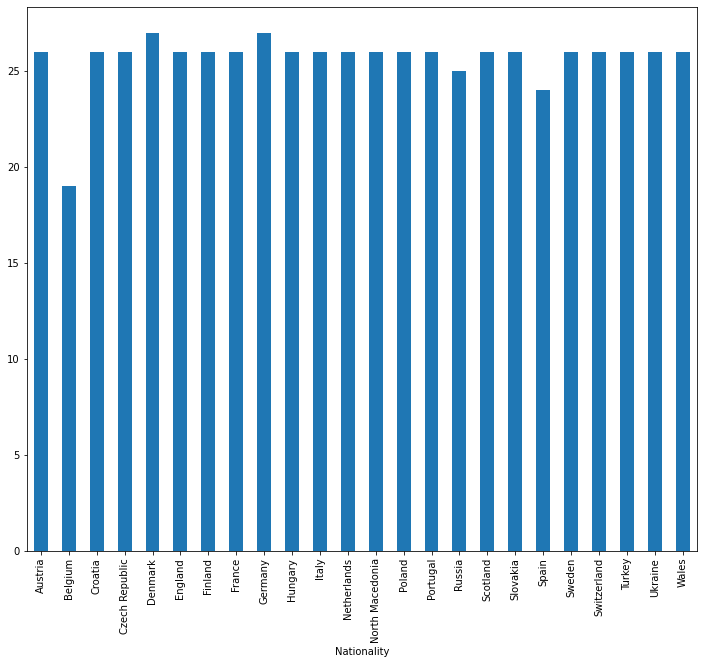

In [53]:
fig, ax = plt.subplots(figsize=(12,10))
EC_teams.groupby('Nationality').size().plot(kind='bar')

We can see that most of the teams have around 25 players. We notice that we have scraped much less player names of North Macedonia. It might be necessary to manually complete these information.

### Comparison of the average overall team ratings

<AxesSubplot:xlabel='Nationality'>

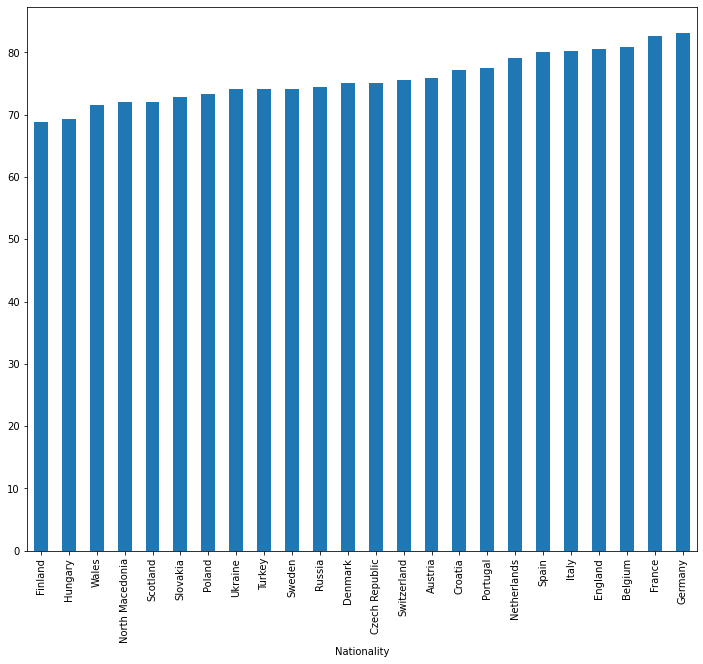

In [54]:
fig, ax = plt.subplots(figsize=(12,10))
EC_teams.groupby('Nationality')['int_overall_rating'].mean().sort_values().plot(kind='bar')

Just looking at the overall_ratings of the players, Germany France and the Netherlands are the strongest competitors in the tournament.

### Average age per team

In [59]:
from datetime import datetime
EC_teams['dt_date_of_birth'] = pd.to_datetime(EC_teams['dt_date_of_birth'])
EC_teams['age'] = (datetime.now() - EC_teams['dt_date_of_birth']).astype('<m8[Y]')
EC_teams.groupby('Nationality')['age'].mean().sort_values(ascending=False)

Nationality
Belgium            29.105263
Sweden             28.923077
North Macedonia    27.800000
Russia             27.761905
Finland            27.666667
Hungary            27.550000
France             27.500000
Germany            27.400000
Austria            27.384615
Slovakia           27.190476
Italy              27.125000
Croatia            27.080000
Czech Republic     27.041667
Denmark            26.851852
Netherlands        26.807692
Poland             26.653846
Spain              26.611111
Switzerland        26.440000
Scotland           26.360000
Portugal           26.000000
Ukraine            25.826087
Wales              25.280000
England            24.576923
Turkey             24.576923
Name: age, dtype: float64

Here we can see the sorted list of the average age of the team. Sweden has the oldest team and Portugal has the youngest one. 

### Heading abilities of the players
In order to keep the graphs more comprehensible, we are only going to show the data of two teams in this graph.

<AxesSubplot:xlabel='int_height', ylabel='int_heading_accuracy'>

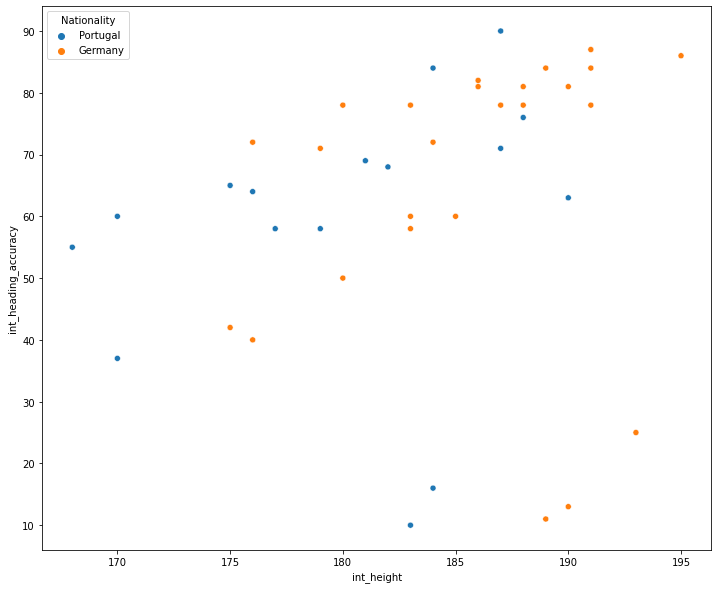

In [60]:
teams_subset = ['Portugal', 'Germany']
fig, ax = plt.subplots(figsize=(12,10))
sns.scatterplot(data=EC_teams[EC_teams['Nationality'].isin(teams_subset)], x='int_height', y='int_heading_accuracy', hue='Nationality')

We can see that the Germans are taller than that a lot of them have a high heading accuracy. We could identify with such an analysis a weakness of the portugese team. Nevertheless, the graph is still quite noisy and it would be good to identify the defenders and attacking players in order to compare who plays against who. This would refine our analysis. Moreover it would be nice to see what player we are talking about when hovering over it. This is a feature that we should implement in our graphs. 

We can build many more of these graphs were we compare the abilities of different players. In our project, we will need to find ways to compare all these different abilities of adversary plays in a meaningful way.

In [61]:
EC_teams[EC_teams['str_nationality'] == 'North Macedonia']

,Nationality,Name,merge_list,int_player_id,str_player_name,str_positions,dt_date_of_birth,int_height,int_weight,int_overall_rating,...,str_work_rate,str_body_type,int_dribbling,int_curve,int_fk_accuracy,int_long_passing,int_ball_control,str_player_speciality,str_trait,age
293,North Macedonia,Stole Dimitrievski,4266.0,4266.0,Stole Dimitrievski,GK,1993-12-25,188.0,81.0,71.0,...,Medium/ Medium,Normal (185+),18.0,17.0,17.0,27.0,19.0,NaN,['Team Player'],27.0
294,North Macedonia,Damjan Siskovski,1054.0,1054.0,Stefan Ristovski,"RWB, RM",1992-02-12,180.0,72.0,77.0,...,Medium/ Medium,Normal (170-185),71.0,67.0,34.0,68.0,74.0,NaN,"['Long Throw-in', 'Speed Dribbler (AI)']",29.0
296,North Macedonia,Stefan Ristovski,1054.0,1054.0,Stefan Ristovski,"RWB, RM",1992-02-12,180.0,72.0,77.0,...,Medium/ Medium,Normal (170-185),71.0,67.0,34.0,68.0,74.0,NaN,"['Long Throw-in', 'Speed Dribbler (AI)']",29.0
299,North Macedonia,Kire Ristevski,1054.0,1054.0,Stefan Ristovski,"RWB, RM",1992-02-12,180.0,72.0,77.0,...,Medium/ Medium,Normal (170-185),71.0,67.0,34.0,68.0,74.0,NaN,"['Long Throw-in', 'Speed Dribbler (AI)']",29.0
300,North Macedonia,Gjoko Zajkov,12321.0,12321.0,Gjoko Zajkov,CB,1995-02-10,186.0,78.0,63.0,...,Low/ Medium,Normal (185+),38.0,19.0,21.0,59.0,48.0,NaN,['Long Passer (AI)'],26.0
302,North Macedonia,Ezdzan Alioski,2941.0,2941.0,Ezgjan Alioski,"LB, LM",1992-02-12,172.0,63.0,73.0,...,High/ High,Normal (170-185),67.0,63.0,64.0,67.0,69.0,['Engine'],"['Solid Player', 'Long Shot Taker (AI)']",29.0
303,North Macedonia,Arijan Ademi,1221.0,1221.0,Arijan Ademi,"CDM, CM",1991-05-29,185.0,79.0,76.0,...,High/ High,Normal (185+),72.0,49.0,48.0,73.0,69.0,['Engine'],"['Injury Prone', 'Leadership', 'Team Player']",30.0
304,North Macedonia,Enis Bardhi,527.0,527.0,Enis Bardhi,"LM, CM",1995-07-02,172.0,64.0,79.0,...,Medium/ Medium,Normal (170-185),82.0,89.0,91.0,74.0,81.0,['FK Specialist'],"['Long Shot Taker (AI)', 'Outside Foot Shot']",25.0
305,North Macedonia,Stefan Spirovski,1054.0,1054.0,Stefan Ristovski,"RWB, RM",1992-02-12,180.0,72.0,77.0,...,Medium/ Medium,Normal (170-185),71.0,67.0,34.0,68.0,74.0,NaN,"['Long Throw-in', 'Speed Dribbler (AI)']",29.0
308,North Macedonia,Ferhan Hasani,7739.0,7739.0,Ferhan Hasani,"CAM, LW",1990-06-18,189.0,76.0,67.0,...,High/ Medium,Normal (185+),71.0,74.0,73.0,64.0,70.0,NaN,"['Injury Prone', 'Technical Dribbler (AI)']",30.0


In [66]:
EC_teams = EC_teams.drop(columns=['Name'])
EC_teams.to_json('teams_basic_skills.json', orient='records')

In [63]:
position_dict = {
                      "GK": "Goalkeeper",
                      "CB": "Center-back",
                      "LCB": "Left center-back",
                      "RCB": "Right center-back",
                      "LB": "Left-back (Full-back)",
                      "RB": "Right-back (Full-back)}",
                      "CM": "Centre midfield",
                      "LDM": "Left center midfield",
                      "LAM": "Left attacking midfield",
                      "RDM": "Right center midfield",
                      "RAM": "Right attacking midfield",
                      "CDM": "Centre defensive midfield",
                      "CAM": "Centre attacking midfield",
                      "LM": "Left midfield",
                      "RM": "Right midfield",
                      "ST": "Striker",
                      "CF": "Center forward",
                      "LW": "Left winger",
                      "RW": "Right winger"
                    }


In [24]:
position_dict

{'GK': 'Goalkeeper',
 'CB': 'Center-back',
 'LCB': 'Left center-back',
 'RCB': 'Right center-back',
 'LB': 'Left-back (Full-back)',
 'RB': 'Right-back (Full-back)}',
 'CM': 'Centre midfield',
 'LDM': 'Left center midfield',
 'LAM': 'Left attacking midfield',
 'RDM': 'Right center midfield',
 'RAM': 'Right attacking midfield',
 'CDM': 'Centre defensive midfield',
 'CAM': 'Centre attacking midfield',
 'LM': 'Left midfield',
 'RM': 'Right midfield',
 'ST': 'Striker',
 'CF': 'Center forward',
 'LW': 'Left winger',
 'RW': 'Right winger'}

In [6]:
import json
with open('website/data/position_dict.json', 'w') as f:
    json.dump(position_dict, f)